# 1. Data Extraction
## 


In [1]:
# Import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Import timeseries sales data using Date column as index

df = pd.read_csv('../timeseries-forecasting/salesdata.csv', index_col='OrderDate', parse_dates=True)
df

,QtyOrdered
OrderDate,
2019-01-01,17828
2019-01-02,24361
2019-01-03,34678
2019-01-04,32561
2019-01-05,27595
...,...
2021-12-27,121599
2021-12-28,65161
2021-12-29,66323


In [17]:
# Explore dataset

df.describe()

,QtyOrdered
count,1096.000000
mean,57089.639599
std,26547.674989
min,11802.000000
25%,38937.000000
50%,52820.000000
75%,69706.000000
max,352569.000000


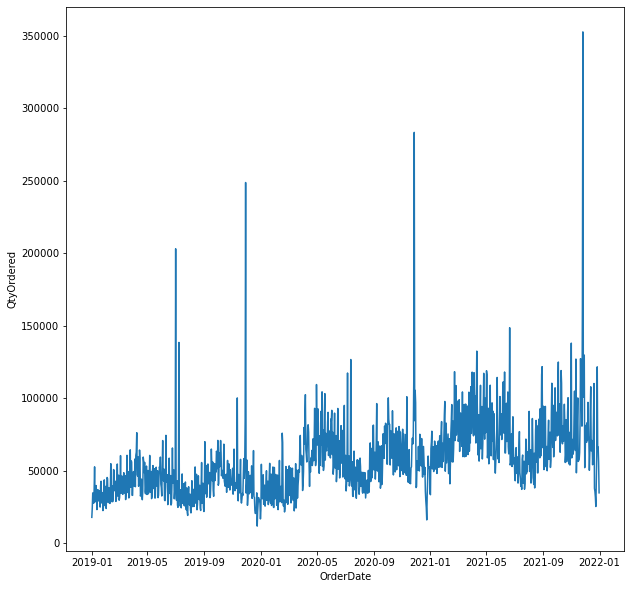

In [18]:
plt.figure(figsize=(10,10))
sns.lineplot(x=df.index, y=df.QtyOrdered);

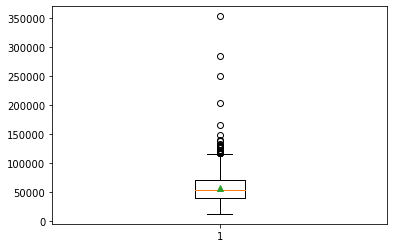

In [26]:
bp = plt.boxplot(x=df.QtyOrdered, showmeans=True);

In [46]:
# Show stats from boxplot using 'means' accessor that was enabled in showmeans=True parameter above

for key in bp:
    print(f'{key}: {[item.get_ydata() for item in bp[key]]}\n')

whiskers: [array([38937., 11802.]), array([ 69706., 114295.])]

caps: [array([11802, 11802], dtype=int64), array([114295, 114295], dtype=int64)]

boxes: [array([38937., 38937., 69706., 69706., 38937.])]

medians: [array([52820., 52820.])]

fliers: [array([203012, 138443, 248708, 117361, 126667, 283295, 118272, 117961,
       117590, 132452, 117166, 118945, 116239, 118053, 148577, 116136,
       121745, 124926, 119054, 137968, 126986, 127259, 164765, 352569,
       128251, 129750, 121599], dtype=int64)]

means: [array([57089.63959854])]



In [48]:
# Access the upper whisker value to set a threshold for outliers that need to be dealt with

upper_whisker_obj = bp['whiskers'][1]
upper_whisker = upper_whisker_obj.get_ydata()[1]